# Experimento08: Transformers (BERT) con datos PRE-PROCESADOS

## Librerías

In [2]:
# Librerias necesarias
import os

# Matplotlib conf
import matplotlib.pyplot as plt
%matplotlib inline
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':40,
         'ytick.labelsize': 40
}
plt.rcParams.update(params)
# Seaborn conf
import seaborn as sns
sns.set(style='darkgrid')
sns.set_palette(sns.color_palette("Blues"))

import sys

#Procesado de datos
import pandas as pd
import numpy as np
import operator

#Modelos
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


from sklearn.decomposition import TruncatedSVD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

from sklearn import preprocessing
from nltk import ngrams

from keras.layers import Dense, Embedding, Flatten, GlobalMaxPool1D, Dropout
from keras.models import Sequential, Model
from tensorflow.keras.layers import Input
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping

from tensorflow.keras import regularizers

from keras.initializers import Constant

from wordcloud import WordCloud

from sklearn.decomposition import TruncatedSVD
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import plot_model
import tensorflow as tf

from sklearn import preprocessing
from nltk import ngrams

from tensorflow.keras import regularizers

# compatibilidad de Keras 2 con TensorFlow 2.16
# da problemas con la librería transformers al compilar el modelo

import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

#primero importamos los paquetes necesarios para trabajar
import transformers
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import re
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy

#si no queremos ver los warnings
import warnings
warnings.filterwarnings("ignore")


## Carga de datos y preproceso

In [3]:
df_training = pd.read_csv("./data/ds_training_processed.csv")
df_testing = pd.read_csv("./data/ds_testing_processed.csv")

X_train = df_training["text"]
y_train = df_training["sentiment"]
X_test = df_testing["text"]
y_test = df_testing["sentiment"]

y_train_2 = to_categorical(y_train, num_classes=2)
y_test_2 = to_categorical(y_test, num_classes=2)

## Funciones generales

In [4]:
pd.set_option('display.max_colwidth', 2000)
vocab_size = 29773
emb_dim = 50
num_words = 29773

results = []
def add_to_results(classifier, repmodel, predict_x, y_test):
    y_pred = get_labels_from_logits(predict_x)

    results.append({"classifier": classifier,
                    "rep.model": repmodel,
                    "accuracy": accuracy_score(y_test, y_pred),
                    "precision": precision_score(y_test, y_pred, average="weighted"),
                    "recall": recall_score(y_test,y_pred, average="weighted")
                    })

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'bo', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.xlabel("Epochs")
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

def nn_classification_report(predict_x, y_test, class_names):
    y_pred = get_labels_from_logits(predict_x)

    print("Classification Report")
    print

    print(classification_report(y_true=y_test, y_pred=y_pred, target_names=class_names))
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

    plot_confusion_matrix(cm, classes=class_names)

    print("Final Accuracy")
    print(accuracy_score(y_test, y_pred))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def join_csv_for_experiment(experiment_string, number_of_experiements):
    experiments_data = []
    for i in range(1, number_of_experiements+1):
        experiments_data.append( pd.read_csv("exp_"+experiment_string+"_"+str(i)+".csv") )

    res = pd.concat(experiments_data, ignore_index=True)
    res.to_csv("exp_"+experiment_string+".csv")

def get_labels_from_logits(preds):
    exp = "08"
    logits = preds.logits
    probs = tf.nn.sigmoid(logits).numpy()
    predicted_labels = (probs > 0.5).astype(int).flatten()
    # print(accuracy_score(y_test, predicted_labels))
    return predicted_labels

## Clasificadores

In [5]:
transformer_model_name = 'bert-base-uncased'

#cargamos el tokenizador correspondiente al modelo con el que vamos a trabajar, ya que así tokenizará la entrada en el
#formato que se pre-entrenó el modelo

model_tokenizer = AutoTokenizer.from_pretrained(transformer_model_name)

#procedemos a tokenizar la entrada usando el tokenizador cargado
#indicamos que la entrada se corte si es más larga de lo que acepta el modelo y que si la entrada es más corta,
#se rellene (padding)
train_encodings = model_tokenizer(list(X_train), truncation=True, padding=True)

In [6]:
print(train_encodings["input_ids"][0][:25])
print(train_encodings["attention_mask"][0][:25])
print(X_train[0][:25])

for token_id in train_encodings["input_ids"][0][:25]:
    print("id:", token_id, "\ttoken:", model_tokenizer.decode(token_id))

print(model_tokenizer.decode(train_encodings["input_ids"][0][:20]))

[101, 2773, 3243, 6235, 3117, 14726, 11333, 3432, 2723, 2098, 2373, 9423, 18238, 1005, 1055, 2773, 2491, 2466, 7354, 8233, 5415, 13048, 2071, 3087, 2064]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
word quite describe novel
id: 101 	token: [CLS]
id: 2773 	token: word
id: 3243 	token: quite
id: 6235 	token: describe
id: 3117 	token: novel
id: 14726 	token: stunning
id: 11333 	token: wa
id: 3432 	token: simply
id: 2723 	token: floor
id: 2098 	token: ##ed
id: 2373 	token: power
id: 9423 	token: rebecca
id: 18238 	token: godfrey
id: 1005 	token: '
id: 1055 	token: s
id: 2773 	token: word
id: 2491 	token: control
id: 2466 	token: story
id: 7354 	token: sara
id: 8233 	token: shaw
id: 5415 	token: universal
id: 13048 	token: singular
id: 2071 	token: could
id: 3087 	token: anyone
id: 2064 	token: can
[CLS] word quite describe novel stunning wa simply floored power rebecca godfrey's word control story sara shaw


In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train))
test_encodings = model_tokenizer(list(X_test),
                            truncation=True,
                            padding=True)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), y_test))

2024-06-13 19:22:28.785747: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-13 19:22:28.786652: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-13 19:22:28.786828: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [8]:
def exp08_train_bert(num_epochs, model_parameters):
    model_description = "Exp08BERT"
    batch_size = 16
    
    model = TFAutoModelForSequenceClassification.from_pretrained(transformer_model_name,num_labels=1,from_pt=True)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), loss=BinaryCrossentropy(from_logits=True),metrics=["accuracy"])
    model.summary()
    history = model.fit(train_dataset.shuffle(len(X_train)).batch(batch_size),epochs=num_epochs,batch_size=batch_size)
    y_predicted = model.predict(test_dataset.batch(batch_size))
    nn_classification_report(y_predicted, y_test, ["NEGATIVE","POSITIVE"])
    add_to_results(model_description + " " + model_parameters, "", y_predicted, y_test)  

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  769       
                                                                 
Total params: 109483009 (417.64 MB)
Trainable params: 109483009 (417.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-06-13 19:25:41.963184: I external/local_xla/xla/service/service.cc:168] XLA service 0x729c6416a960 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-13 19:25:41.963223: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-06-13 19:25:41.972321: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-13 19:25:41.995129: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1718299542.051939   55934 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 [==============================] - 14s 100ms/step
Classification Report
              precision    recall  f1-score   support

    NEGATIVE       0.92      0.86      0.89       999
    POSITIVE       0.87      0.93      0.90       998

    accuracy                           0.89      1997
   macro avg       0.89      0.89      0.89      1997
weighted avg       0.89      0.89      0.89      1997

Confusion matrix, without normalization


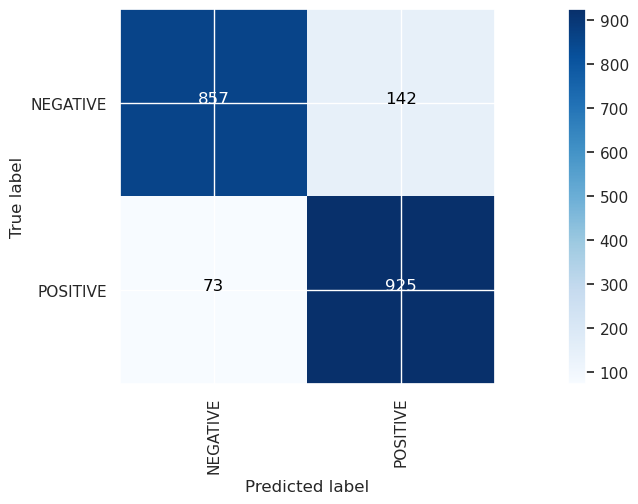

Final Accuracy
0.8923385077616425


In [9]:
results = []
exp08_train_bert(num_epochs=1, model_parameters="epochs=1 data=PREPROCESSED")
partial = pd.DataFrame(results)
partial.to_csv("exp_08_4.csv", index=False)  

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_75 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  769       
                                                                 
Total params: 109483009 (417.64 MB)
Trainable params: 109483009 (417.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
625/625 [==============================] - 212s 306ms/step - loss: 0.2733 - accuracy: 0.8856
Epoch 2/2
125/125 [==============================] - 14s 100ms/step
Classification Report
              precision    recall  f1-score   support


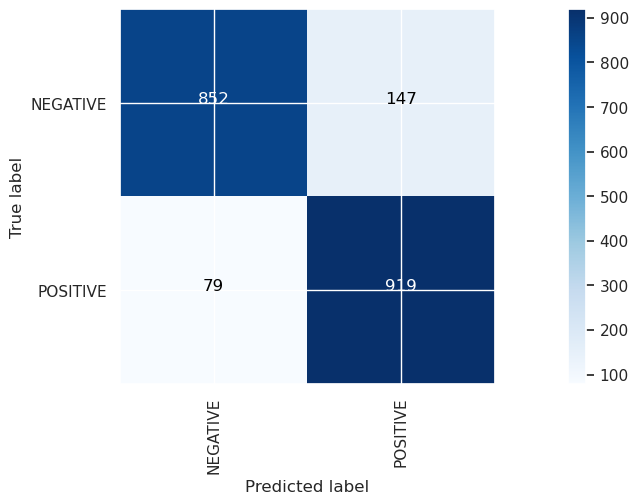

Final Accuracy
0.8868302453680521


In [10]:
results = []
exp08_train_bert(num_epochs=2, model_parameters="epochs=2 data=PREPROCESSED")
partial = pd.DataFrame(results)
partial.to_csv("exp_08_5.csv", index=False)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_113 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  769       
                                                                 
Total params: 109483009 (417.64 MB)
Trainable params: 109483009 (417.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/3
625/625 [==============================] - 213s 307ms/step - loss: 0.2639 - accuracy: 0.8888
Epoch 2/3
625/625 [==============================] - 192s 307ms/step - loss: 0.1159 - accuracy: 0.9605
Epoch 3/3
125/125 [======================

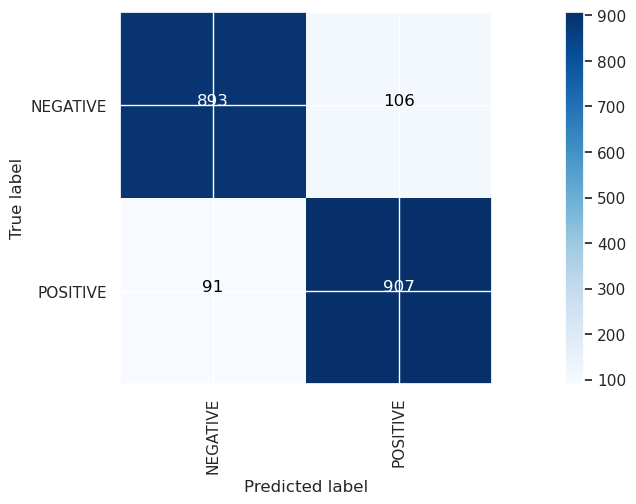

Final Accuracy
0.901352028042063


In [11]:
results = []
exp08_train_bert(num_epochs=3, model_parameters="epochs=3 data=PREPROCESSED")
partial = pd.DataFrame(results)
partial.to_csv("exp_08_6.csv", index=False)

## Conclusiones

In [12]:
join_csv_for_experiment("08", 6)
pd.read_csv("exp_08.csv").sort_values(by=["accuracy"], ascending=False, ignore_index=True)[["classifier", "rep.model", "accuracy","precision","recall"]]

,classifier,rep.model,accuracy,precision,recall
0,Exp08BERT epochs=2 data=raw,NaN,0.945000,0.947191,0.945000
1,Exp08BERT epochs=1 data=raw,NaN,0.940000,0.941485,0.940000
2,Exp08BERT epochs=3 data=raw,NaN,0.938500,0.938521,0.938500
3,Exp08BERT epochs=3 data=PREPROCESSED,NaN,0.901352,0.901443,0.901352
4,Exp08BERT epochs=1 data=PREPROCESSED,NaN,0.892339,0.894225,0.892339
5,Exp08BERT epochs=2 data=PREPROCESSED,NaN,0.886830,0.888636,0.886830
